# Introduction

The task is to classify [jet data](https://zenodo.org/record/3164691#.YigdGt9MHrB) into quark jets and gluon jets. For this, I used [ParticleNet](https://arxiv.org/abs/1902.08570), which I implemented in pytorch. The architecture of the network is as shown in the images below (images are taken from the paper itself.)

<!-- ![EdgeConv Block](https://drive.google.com/file/d/1Rjb3b1R3_fn5pPQYJ7oNDLgcrgWFDiGq/view?usp=sharing) -->

<!-- ![Model](https://drive.google.com/file/d/12ExseD2p-zHVB5U7nYo8qvpIKAlnQnv7/view?usp=sharing) -->

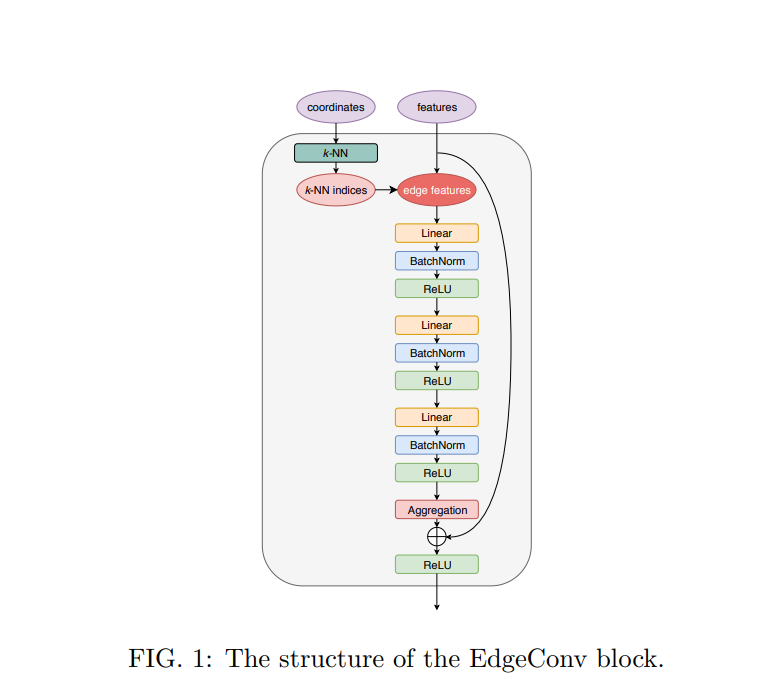


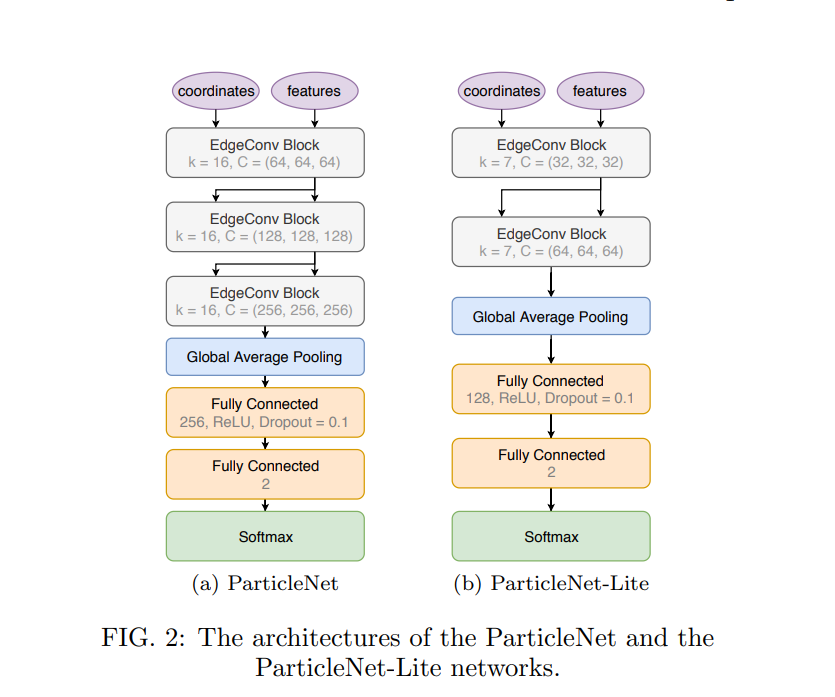

# Install and Import Libraries

In [2]:
! pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 7.9 MB/s 
     |████████████████████████████████| 3.5 MB 67.7 MB/s 
     |████████████████████████████████| 2.5 MB 64.6 MB/s 
     |████████████████████████████████| 750 kB 29.1 MB/s 
     |████████████████████████████████| 407 kB 8.8 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=8b1d6519e77257c240748033293da6f6e4466e27a9e1778fed62ad3749dc9be9
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric


In [1]:
!pip install wandb

     |████████████████████████████████| 1.8 MB 8.1 MB/s 
     |████████████████████████████████| 181 kB 62.1 MB/s 
     |████████████████████████████████| 144 kB 72.7 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=05f0a258d49ea5351617bbd2eb121a0ee7876e9a8a14af7d1150b0c5d517c942
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [3]:
## Import stuff
import os
import logging
import requests
import time
import functools
import pathlib
import shutil
import typing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import wandb

import torch
import torch_geometric
import tqdm.auto as tqdm

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
!wandb login bf2b5ed9106ef05fd0272342f630256c3b647170

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Data Preprocessing

The data shape is (1e5, 139, 4). Here there are 50,000 each quark and gluon data points. Each data point contains upto 139 particle features. This data point is converted into a graph using KNN on the first two features (which corresponds to distance.) Then the graphs are passed to the GNN for edge convolution followed by a fully connected layer for classification (as depicted in the deagram above.)

In [4]:
class JetDataset(torch_geometric.data.InMemoryDataset):
    """
    Quark/Gluon tagging dataset.
    """

    _url = 'https://zenodo.org/record/3164691/files/QG_jets.npz'
    _jets_per_file = 1e5

    def __init__(self, root: str, dataset: str):
        """
        Create the ParticleNet dataset class.
        Downloads and Processes the data if prepared files do not exist
        Delete processed files to regenerate dataset
        :type root: str
        :param root: The directory in which all datasets will be placed
        """
        super().__init__(root)
        self.data, self.slices = torch.load(os.path.join(self.raw_dir, f"{dataset}.pt"))

    @property
    def raw_dir(self) -> str:
        """
        Directory in which the zenodo download files are stored
        :rtype: str
        :return: path to the directory where raw data is being housed
        """
        return self.root

    @property
    def processed_dir(self) -> str:
        """
        Directory in which the processed graphs are stored.
        :rtype: str
        :return: path to the directory where processed data is being housed
        """
        return self.root

    @property
    def raw_file_names(self) -> typing.List[str]:
        """
        List of raw data file names being downloaded and extracted from zenodo
        :rtype: List[str]
        :return: List of file names
        """
        return ["QG_jets.npz"]

    @property
    def processed_file_names(self) -> typing.List[str]:
        """
        List of processed data file names which have been generated from 
        processing raw data in zenodo
        :rtype: List[str]
        :return: List of file names which house torch_geometric graph data
        """
        return ["train.pt", "test.pt", "val.pt"]

    def __len__(self):
        """
        Gives the total number of jets in the dataset
        """
        return len(self.data['y'])

    def download(self) -> None:
        os.makedirs(os.path.join(self.raw_dir), exist_ok=True)
        filename = os.path.join(self.raw_paths[0])

        r = requests.get(self._url, stream=True, allow_redirects=True)
        if r.status_code != 200:
            r.raise_for_status()
            raise RuntimeError(f"Request to {self._url} returned status code {r.status_code}")
        file_size = int(r.headers.get('Content-Length', 0))

        path = pathlib.Path(filename).expanduser().resolve()
        path.parent.mkdir(parents=True, exist_ok=True)

        r.raw.read = functools.partial(r.raw.read, decode_content=True)
        with tqdm.tqdm.wrapattr(r.raw, "read", total=file_size) as r_raw:
            with path.open("wb") as f:
                shutil.copyfileobj(r_raw, f)

    def process(self) -> None:
      raw_data = np.load(self.raw_paths[0])
 
      train_x, train_y = raw_data['X'][:60000], raw_data['y'][:60000]
      test_x, test_y = raw_data['X'][60000:80000], raw_data['y'][60000:80000]
      val_x, val_y = raw_data['X'][80000:], raw_data['y'][80000:]

      for name, x, y in [("train", train_x, train_y), ("test", test_x, test_y), ("val", val_x, val_y)]:
        graphs = []
        for graph, label in tqdm.tqdm(zip(x, y), total=len(y)):
            nodes = graph[graph[:, 3] > 1e-8]
            graphs.append(
                torch_geometric.data.Data(
                    x=torch.from_numpy(nodes[:, :3]).float(),
                    pos=torch.from_numpy(nodes[:, :2]).float(),
                    y=torch.tensor(label).long()
                )
            )
        torch.save(
            self.collate(graphs),
            os.path.join(self.processed_dir, f"{name}.pt"),
        )

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"


# ParticleNet Implementation

In [6]:
class ParticleStaticEdgeConv(torch_geometric.nn.MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(ParticleStaticEdgeConv, self).__init__(aggr='max')
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * in_channels, out_channels[0], bias=False),
            torch_geometric.nn.BatchNorm(out_channels[0]), 
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels[0], out_channels[1], bias=False),
            torch_geometric.nn.BatchNorm(out_channels[1]),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels[1], out_channels[2], bias=False),
            torch_geometric.nn.BatchNorm(out_channels[2]),
            torch.nn.ReLU()
        )

    def forward(self, x, edge_index):
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)

    def message(self, x_i, x_j):
        tmp = torch.cat([x_i, x_j - x_i], dim = 1)
        return self.mlp(tmp)

    def update(self, aggr_out):
        return aggr_out

class ParticleDynamicEdgeConv(ParticleStaticEdgeConv):
    def __init__(self, in_channels, out_channels, k=7):
        super(ParticleDynamicEdgeConv, self).__init__(in_channels, out_channels)
        self.k = k
        self.skip_mlp = torch.nn.Sequential(
            torch.nn.Linear(in_channels, out_channels[2], bias=False),
            torch_geometric.nn.BatchNorm(out_channels[2]),
        )
        self.act = torch.nn.ReLU()

    def forward(self, pts, fts, batch=None):
        edges = torch_geometric.nn.knn_graph(pts, self.k, batch, loop=False, flow=self.flow)
        aggrg = super().forward(fts, edges)
        x = self.skip_mlp(fts)
        out = torch.add(aggrg, x)
        return self.act(out)

In [7]:
class ParticleNet(torch.nn.Module):

    def __init__(self, settings):
        super().__init__()
        previous_output_shape = settings['input_features']

        self.input_bn = torch_geometric.nn.BatchNorm(settings['input_features'])

        self.conv_process = torch.nn.ModuleList()
        for layer_idx, layer_param in enumerate(settings['conv_params']):
            K, channels = layer_param
            self.conv_process.append(ParticleDynamicEdgeConv(previous_output_shape, channels, k=K).to(DEVICE))
            previous_output_shape = channels[-1]

        self.fc_process = torch.nn.ModuleList()
        for layer_idx, layer_param in enumerate(settings['fc_params']):
            drop_rate, units = layer_param
            seq = torch.nn.Sequential(
                torch.nn.Linear(previous_output_shape, units),
                torch.nn.Dropout(p=drop_rate),
                torch.nn.ReLU()
            ).to(DEVICE)
            self.fc_process.append(seq)
            previous_output_shape = units

        self.output_mlp_linear = torch.nn.Linear(previous_output_shape, settings['output_classes'])
        self.output_activation = torch.nn.Softmax(dim=1)

    def forward(self, batch):
        fts = self.input_bn(batch.x)
        pts = batch.pos

        for idx, layer in enumerate(self.conv_process):
            fts = layer(pts, fts, batch.batch)
            pts = fts

        x = torch_geometric.nn.global_mean_pool(fts, batch.batch)

        for layer in self.fc_process:
            x = layer(x)

        x = self.output_mlp_linear(x)
        x = self.output_activation(x)
        return x

### Training the model

In [8]:
def train(model, optimizer, train_dataloader, val_dataloader, epochs=10):

    batch_losses, batch_accuracy = [], []
    val_batch_losses, val_batch_accuracy = [], []

    for epoch in range(epochs):
        model.train()
        total_loss, total_samples, total_correct = 0, 0, 0
        train_iterator = tqdm.tqdm(train_dataloader, desc=f'Training Epoch {epoch}')
        for batch in train_iterator:
            optimizer.zero_grad()

            batch = batch.to(DEVICE)
            y = batch.y
            out = model(batch)

            loss = criterion(out, y)
            total_loss += loss.item()
            total_samples += y.shape[0]
            total_correct += (torch.max(out, 1)[1] == y).float().sum().item()
            loss.backward()
            optimizer.step()

            train_iterator.set_postfix(
                loss=total_loss/total_samples, 
                accuracy=total_correct/total_samples)

        batch_losses.append(total_loss/total_samples)
        batch_accuracy.append(total_correct/total_samples)

        wandb.log({'Training Accuracy': batch_accuracy[-1], 
                   'Training Loss': batch_losses[-1]})
        
        total_loss, total_samples, total_correct = 0, 0, 0
        with torch.no_grad():
            model.eval()
            val_iterator = tqdm.tqdm(val_dataloader, desc=f'Validation Epoch {epoch}')
            for batch in val_iterator:
                batch = batch.to(DEVICE)
                y = batch.y
                out = model(batch)

                loss = criterion(out, y)
                total_loss += loss.item()
                total_samples += y.shape[0]
                total_correct += (torch.max(out, 1)[1] == y).float().sum().item()

                val_iterator.set_postfix(
                    loss=total_loss/total_samples, 
                    accuracy=total_correct/total_samples
                )
            
            val_batch_losses.append(total_loss/total_samples)
            val_batch_accuracy.append(total_correct/total_samples)

            wandb.log({'Validation Accuracy': val_batch_accuracy[-1], 
                   'Validation Loss': val_batch_losses[-1]})

# Benchmarking ParticleNet

The model is trained and validated here. The results can be visualized in wandb, which also allows for real time tracking and parameter sweeping. 

In [ ]:
!rm -rf data/*.pt

In [10]:
wandb.init(project='particle-net', name='gnn', config=settings, save_code=False)

Training Accuracy,▁▅▅▆▆▇▇▇██
Training Loss,█▅▄▃▃▂▂▂▁▁
Validation Accuracy,▁▁▃▆▆▇▇▇▆█
Validation Loss,█▆▆▄▃▂▂▂▁▁
Training Accuracy,0.76797
Training Loss,0.00829
Validation Accuracy,0.76385
Validation Loss,0.00836


In [11]:
settings = {
    "conv_params": [
        (7, (32, 32, 32)),
        (7, (64, 64, 64))
    ],
    "fc_params": [
        (0.1, 128)
    ],
    "input_features": 3,
    "output_classes": 2,
}


model = ParticleNet(settings)
model = model.to(DEVICE)

train_dataset = JetDataset("data", "train")
test_dataset = JetDataset("data", "test")

train_dataloader = torch_geometric.loader.DataLoader(train_dataset, batch_size=64)
test_dataloader = torch_geometric.loader.DataLoader(test_dataset, batch_size=64)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

train(model, optimizer, train_dataloader, test_dataloader, epochs=10)

Training Epoch 0:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Training Epoch 1:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Training Epoch 2:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Training Epoch 3:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Training Epoch 4:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Training Epoch 5:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Training Epoch 6:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Training Epoch 7:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Training Epoch 8:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Training Epoch 9:   0%|          | 0/938 [00:00<?, ?it/s]

Validation Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

# Discussions and Further Improvements

The above run instantiated only a small model to demonstrate that the implementation works. The results I think can be substantially improved. First, the last feature, particle-id, can be split into 15 features with flags for particle type. This will give the model direct imformation of the particle type and shorten the training time. Next, the model contains a **skip connection**. Therefore, the GNN part can be expanded further, without the fear of over-smoothening. In some previous runs, this gave me a faster and a *slightly* better convergence. We could use huristics from our knowledge of physics to improve classification. I only used one data file from the dataset. In practice, with the availability of more compute, we can append more data and train the network on it. This should also improve the performance. Lastly, the final classification later is just a fully connected NN. We can probably try other architectures here to improve performance. 

Here, **k** in the KNN was hard coaded. Ideally, there should be a parameter sweep run to determine the best hyperparameters. 

**All of this was not done here as this is just a proof of work for a GSoC proposal.**